In [2]:
import os
import numpy as np

import pandas as pd
from pandas.plotting import andrews_curves
from pandas.plotting import parallel_coordinates

from sklearn.cluster import AgglomerativeClustering

import seaborn as sns

#matplotlib and related imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
import matplotlib.patches as patches

from scipy.spatial import ConvexHull
from scipy.signal import find_peaks
from scipy.stats import sem
import scipy.cluster.hierarchy as shc

#import squarify

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.seasonal import seasonal_decompose

from dateutil.parser import parse

from IPython.display import Image

import geopandas
import folium
from folium.plugins import TimeSliderChoropleth
from branca.element import Template, MacroElement

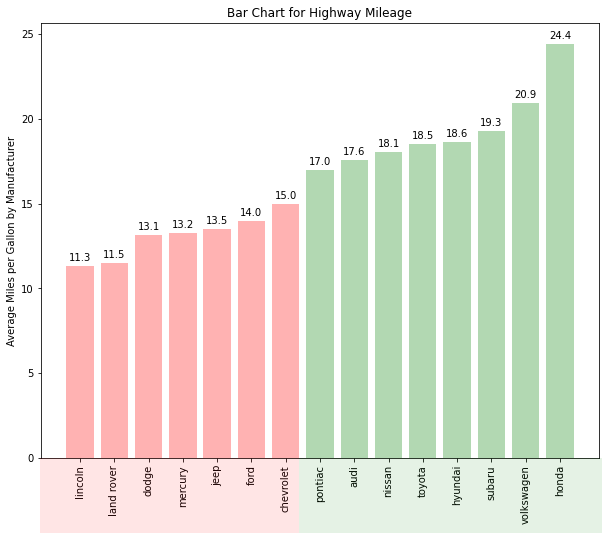

In [5]:
# get the data
path = "./data/mpg_ggplot2.csv"
df = pd.read_csv(path)

# prepare the data for plotting
# groupby and create the target x and y
gb_df = df.groupby(["manufacturer"])["cyl", "displ", "cty"].mean()
gb_df.sort_values("cty", inplace = True)
# fitler x and y
x = gb_df.index
y = gb_df["cty"]

# instanciate the figure
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()

# plot the data
for x_, y_ in zip(x, y):
    # this is very cool, since we can pass a function to matplotlib
    # and it will plot the color based on the result of the evaluation
    ax.bar(x_, y_, color = "red" if y_ < y.mean() else "green", alpha = 0.3)
    
     # add some text
    ax.text(x_, y_ + 0.3, round(y_, 1), horizontalalignment = 'center')

# red one
p2 = patches.Rectangle((.124, -0.005), width = .360, height = .13, alpha = .1, facecolor = 'red', transform = fig.transFigure)
fig.add_artist(p2)

# green one
p1 = patches.Rectangle((.124 + .360, -0.005), width = .42, height = .13, alpha = .1, facecolor = 'green', transform = fig.transFigure)
fig.add_artist(p1)

# rotate the x ticks 90 degrees
ax.set_xticklabels(x, rotation=90)

# add an y label
ax.set_ylabel("Average Miles per Gallon by Manufacturer")

# set a title
ax.set_title("Bar Chart for Highway Mileage");

Text(0.5, 1.0, 'Scatter plot with regression')

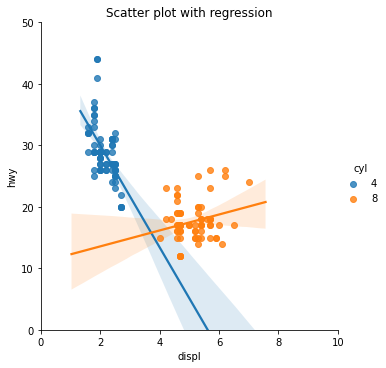

In [3]:
# prepare the data for plotting
# filter only 2 clases to separate it more easily on the plot
df = df[df["cyl"].isin([4,8])]

# plot the data using seaborn
sns.lmplot("displ", "hwy", df, hue = "cyl")

# prettify the plot

# since we are using seaborn and this library uses matplotlib behind the scenes
# you can call plt.gca (get current axes) and use all the familiar matplotlib commands
ax = plt.gca()

# change the upper limit of the plot to make it more pleasant
ax.set_xlim(0, 10)
ax.set_ylim(0, 50)

# set title
ax.set_title("Scatter plot with regression")

Text(0.5, 1.0, 'Jitter plot')

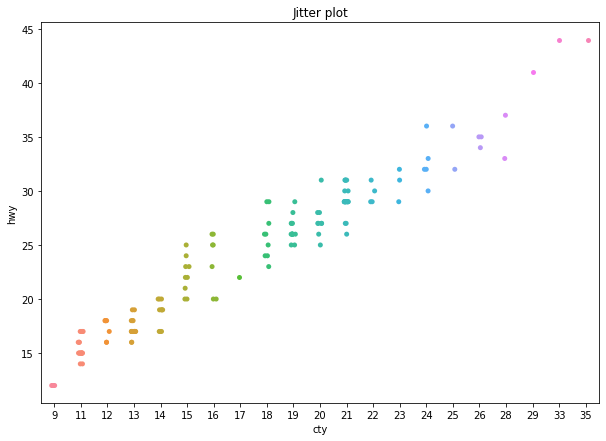

In [4]:
# separate x and y variables
x = df["cty"]
y = df["hwy"]

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
plt.figure(figsize = (10, 7))

# ----------------------------------------------------------------------------------------------------
# plot the data using seaborn
ax = sns.stripplot(x, y)

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# set title
ax.set_title("Jitter plot")

Text(0.5, 1.0, 'Count plot')

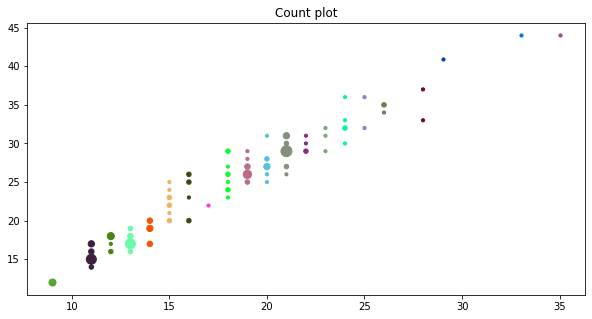

In [5]:
# make a groupby by variables of interest
gb_df = df.groupby(["cty", "hwy"]).size().reset_index(name = "counts") 

# sort the values
gb_df.sort_values(["cty", "hwy", "counts"], ascending = True, inplace = True)

colors = {i:np.random.random(3,) for i in sorted(list(gb_df["cty"].unique()))}

# instanciate the figure
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

# iterate over each category and plot the data. This way, every group has it's own color and sizwe.
for x in sorted(list(gb_df["cty"].unique())):
    
    # get x and y values for each group
    x_values = gb_df[gb_df["cty"] == x]["cty"]
    y_values = gb_df[gb_df["cty"] == x]["hwy"]
    
    # extract the size of each group to plot
    size = gb_df[gb_df["cty"] == x]["counts"]
    
    # extract the color for each group and covert it from rgb to hex
    color = matplotlib.colors.rgb2hex(colors[x])
    
    # plot the data
    ax.scatter(x_values, y_values, s = size*10, c = color)
    
# set title
ax.set_title("Count plot")

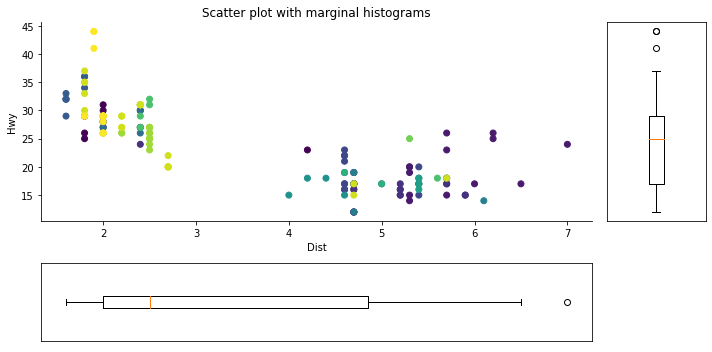

In [6]:
# prepare the data for plotting
x = df["displ"]
y = df["hwy"]

# in this plot we create the colors separatly
colors = df["manufacturer"].astype("category").cat.codes

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (10, 5))
# in this case we use gridspec.
# check the basics section of this kernel if you need help.
gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:4, :-1])

# plot the data

# main axis: scatter plot
# this line is very nice c = df.manufacturer.astype('category').cat.codes
# since it basically generate a color for each category
ax1.scatter(x, y, c = df.manufacturer.astype('category').cat.codes) 

# set the labels for x and y
ax1.set_xlabel("Dist")
ax1.set_ylabel("Hwy")

# set the title for the main plot
ax1.set_title("Scatter plot with marginal histograms")

# prettify the plot
# get rid of some of the spines to make the plot nicer
ax1.spines["right"].set_color("None")
ax1.spines["top"].set_color("None")

# using familiar slicing, get the left axes and plot
ax2 = fig.add_subplot(gs[4:, :-1])
ax2.boxplot(x, 
            vert = False,  
            whis = 0.75 # make the boxplot lines shorter
           )
# prettify the plot
# set the ticks to null
ax2.set_xticks([])
ax2.set_yticks([])

# left plot
ax3 = fig.add_subplot(gs[:4, -1])
ax3.boxplot(y,  
            whis = 0.75 # make the boxplot lines shorter
           )
# prettify the plot
# set the ticks to null
ax3.set_xticks([])
ax3.set_yticks([])

# make all the figures look nicier
fig.tight_layout()

In [7]:
# prepare the data for plotting
gb_df = df[["class", "manufacturer"]].groupby("class")
lx = []
ln = []

# handpicked colors
colors = ["#543005", "#8c510a", "#bf812d", "#80cdc1", "#35978f", "#01665e", "#003c30"]

# iterate over very groupby group and 
# append their values as a list
# THIS IS A CRUCIAL STEP
for _, df_ in gb_df:
    lx.append(df_["manufacturer"].values.tolist())
    ln.append(list(set(df_["class"].values.tolist()))[0])

Text(0, 0.5, 'Frequency')

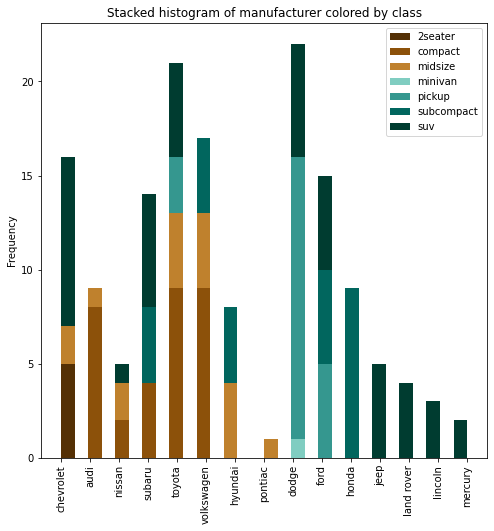

In [9]:
# instanciate the figure
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

# hist returns a tuple of 3 values
# let's unpack it
n, bins, patches = ax.hist(lx, bins = 30, stacked = True, density = False, color = colors)

# prettify the plot

# rotate the x axis label
ax.tick_params(axis = 'x', labelrotation = 90)

# add a custom legend wit class and color
# you have to pass a dict
ax.legend({class_:color for class_, color in zip(ln, colors)})

# add a title
ax.set_title("Stacked histogram of manufacturer colored by class")

# set an y label
ax.set_ylabel("Frequency")

Text(0.5, 1.0, 'Density Plot of City Mileage by n_cilinders')

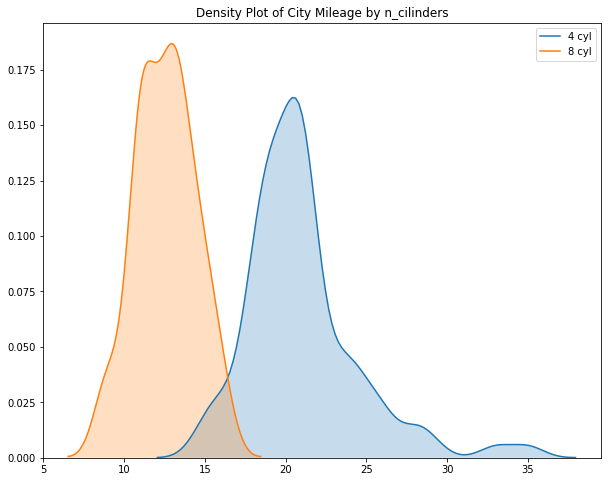

In [10]:
# instanciate the figure
fig = plt.figure(figsize = (10, 8))
# plot the data
# the idea is to iterate over each class
# extract their data ad plot a sepate density plot
for cyl_ in df["cyl"].unique():
    # extract the data
    x = df[df["cyl"] == cyl_]["cty"]
    # plot the data using seaborn
    sns.kdeplot(x, shade=True, label = "{} cyl".format(cyl_))

# set the title of the plot
plt.title("Density Plot of City Mileage by n_cilinders")

/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Density Plot of City Mileage by vehicle type')

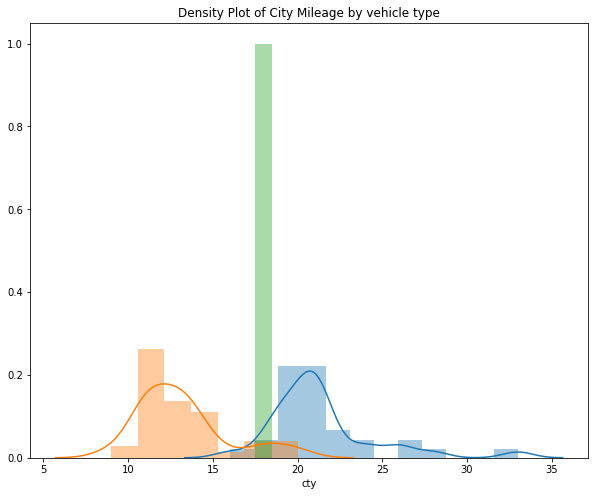

In [11]:
# instanciate the figure
fig = plt.figure(figsize = (10, 8))

# ----------------------------------------------------------------------------------------------------
# plot the data
# the idea is to iterate over each class
# extract their data ad plot a sepate density plot
# with their histogram
for class_ in ["compact", "suv", "minivan"]:
    # extract the data
    x = df[df["class"] == class_]["cty"]
    # plot the data using seaborn
    sns.distplot(x, kde = True, label = "{} class".format(class_))
    
# set the title of the plot
plt.title("Density Plot of City Mileage by vehicle type")

Text(0.5, 1.0, 'Boxplot')

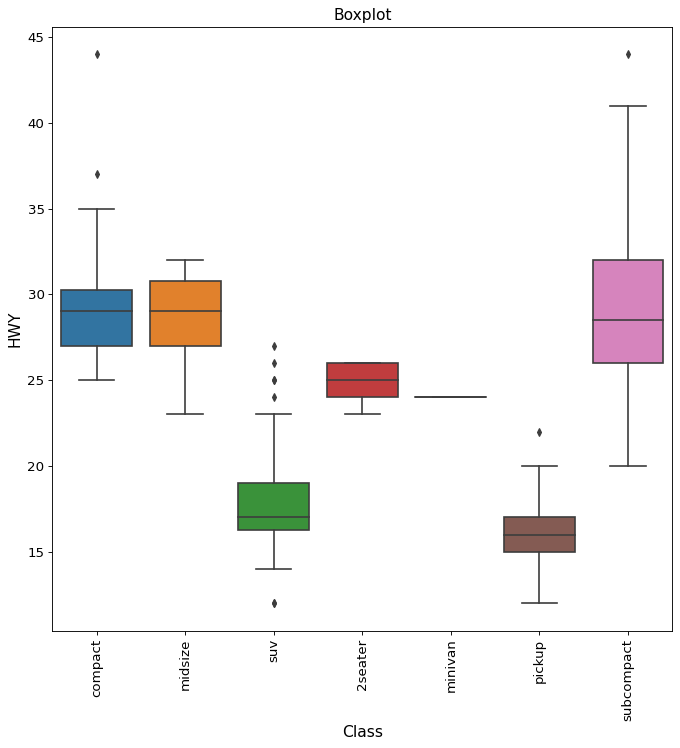

In [13]:
plt.figure(figsize = (10, 10), dpi = 80)
# plot the data using seaborn
ax = sns.boxplot(x = "class", y = "hwy", data = df)


# ----------------------------------------------------------------------------------------------------
# prettify the plot

# change the font of the x and y ticks (numbers on the axis)
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# set and x and y label
ax.set_xlabel("Class", fontsize = 14)
ax.set_ylabel("HWY", fontsize = 14)

# set a title
ax.set_title("Boxplot", fontsize = 14)

In [14]:
# vectors to plot
vects = [df[df["class"] == car]["hwy"] for car in df["class"].unique()]

# labels for the x axis
labels = [class_ for class_ in df["class"].unique()]

# handpicked colors
colors = ["#543005", "#8c510a", "#bf812d", "#80cdc1", "#35978f", "#01665e", "#003c30"]


/Users/marigaldina/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Box plor of Highway Mileage by Vehicle Class')

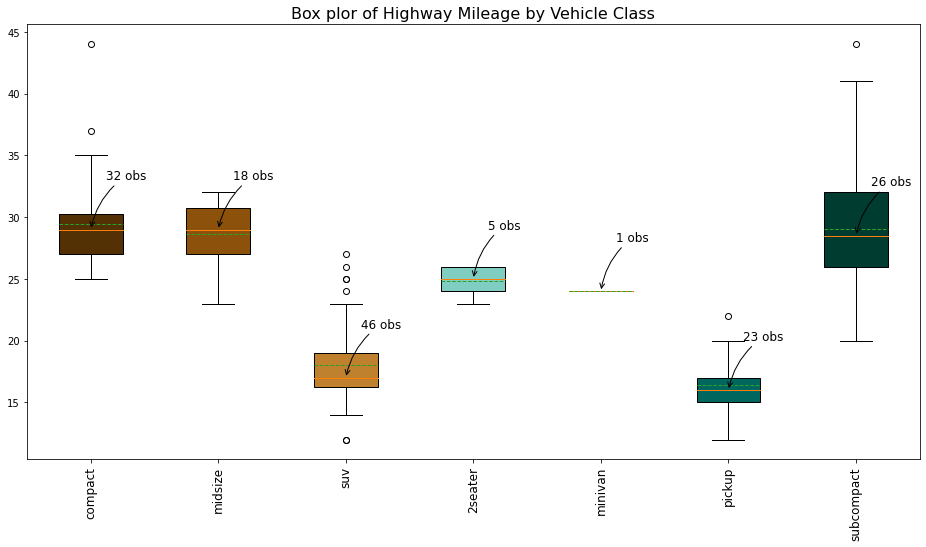

In [16]:
# instanciate the figure
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()
# plot the data using matplotlib
plot1 = ax.boxplot(vects,
    notch = False, 
    vert = True,
    meanline = True,
    showmeans = True,
    patch_artist=True
)
# iterate over every box and add some annotations
for box, color, vect, label, tick in zip(plot1["boxes"], # using this line, you can iterate over every box
                                         colors, 
                                         vects, 
                                         labels, 
                                         ax.get_xticks()):
    # change the color of the box
    box.set(facecolor = color)
    # add text
    ax.annotate("{} obs".format(len(vect)), 
                xy = (tick, np.median(vect)),
               xytext = (15, 50),
               textcoords = "offset points",
               arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=.2"),
               fontsize = 12)
# prettify the plot
# change the x labels
ax.set_xticklabels(labels = labels)

# change the rotation and the size of the x ticks (numbers of x axis)
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)

# set the title for the plot
ax.set_title("Box plor of Highway Mileage by Vehicle Class", fontsize = 16)

Text(0.5, 1.0, 'Violinplot')

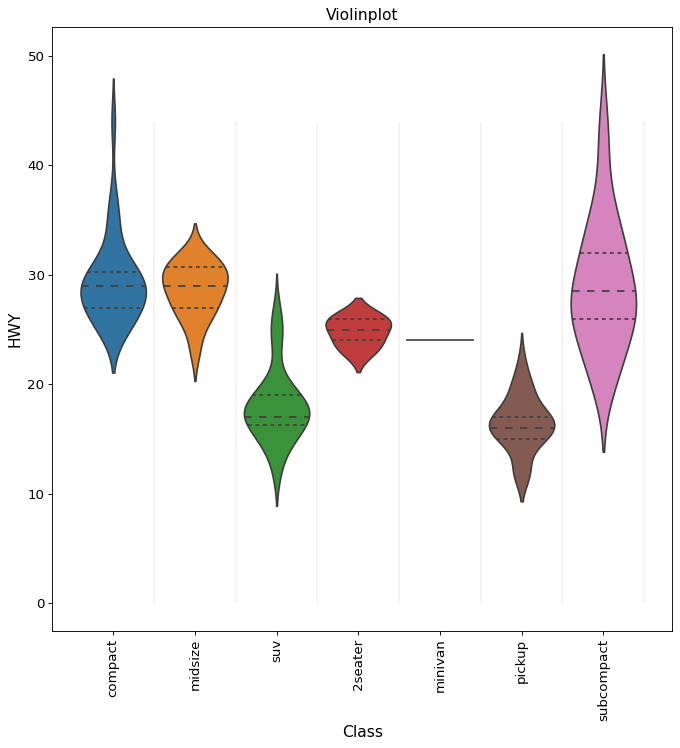

In [18]:
# instanciate the figure
plt.figure(figsize = (10, 10), dpi= 80)
sns.violinplot(x = "class", 
               y = "hwy", 
               data = df, 
               scale = 'width', 
               inner = 'quartile'
              )
# prettify the plot

# get the current figure
ax = plt.gca()
# get the xticks to iterate over
xticks = ax.get_xticks()

# iterate over every xtick and add a vertical line
# to separate different classes
for tick in xticks:
    ax.vlines(tick + 0.5, 0, np.max(df["hwy"]), color = "grey", alpha = .1)
    
# rotate the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# add x and y label
ax.set_xlabel("Class", fontsize = 14)
ax.set_ylabel("HWY", fontsize = 14)

# set title
ax.set_title("Violinplot", fontsize = 14)

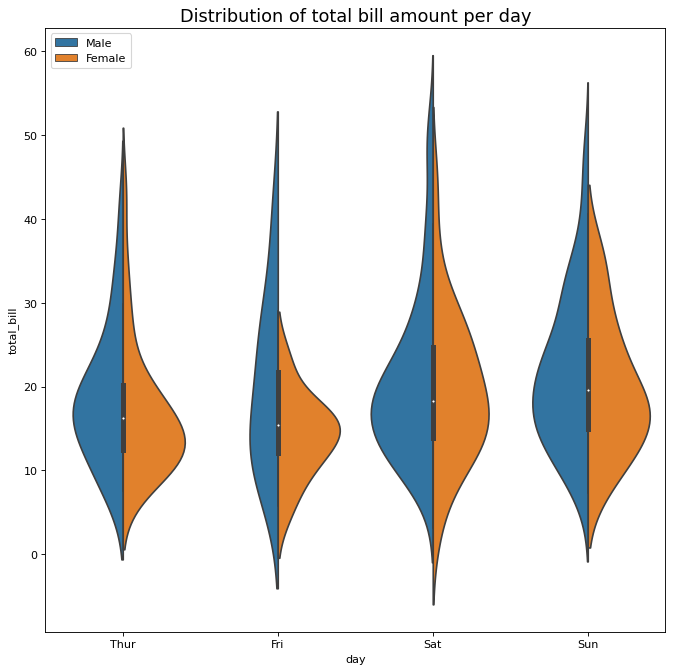

In [19]:
# get the data
tips = sns.load_dataset("tips")

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
plt.figure(figsize = (10, 10), dpi= 80)

# plot the data using seaborn
# the cool thing is that we put split = True and have 4 violin plots instead of 8
ax = sns.violinplot(x = "day", y = "total_bill", hue = "sex", split = True, data = tips)

# ----------------------------------------------------------------------------------------------------
# prettify the plot
# set a title and change the legend location
ax.set_title('Distribution of total bill amount per day', fontsize = 16)
ax.legend(loc = "upper left", fontsize = 10)

In [20]:
# prepare the data for plotting
# create a dictionary of each class and their totals
values = {k:v for k,v in zip(df["class"].value_counts().index, df["class"].value_counts().values)}

# ----------------------------------------------------------------------------------------------------
# plot the data using pywaffle
plt.figure(
    FigureClass = Waffle,
    rows = 7,
    columns = 34,
    values = values,
    legend = {'loc': 'upper left', 'bbox_to_anchor': (1, 1), "fontsize": "12"},
    figsize = (20, 7)
)

# ----------------------------------------------------------------------------------------------------
# prettify the plot
# set a title
plt.title("Waffle chart using pywaffle", fontsize = 12);

NameError: name 'Waffle' is not defined

In [21]:
# get the values
label_value = df["class"].value_counts().to_dict()

# create the labels using a list comprehesion
labels = ["{} has {} obs".format(class_, obs) for class_, obs in label_value.items()]

# create n colors based on the number of labels we have
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

In [22]:
# instanciate the figure
plt.figure(figsize = (20, 10))
# plot the data using squarify
squarify.plot(sizes = label_value.values(), label = labels,  color = colors, alpha = 0.8)
# prettify the plot
# add a title to the plot
plt.title("Treemap using external libraries")

NameError: name 'squarify' is not defined

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Number of Vehicles per Manufacturer')

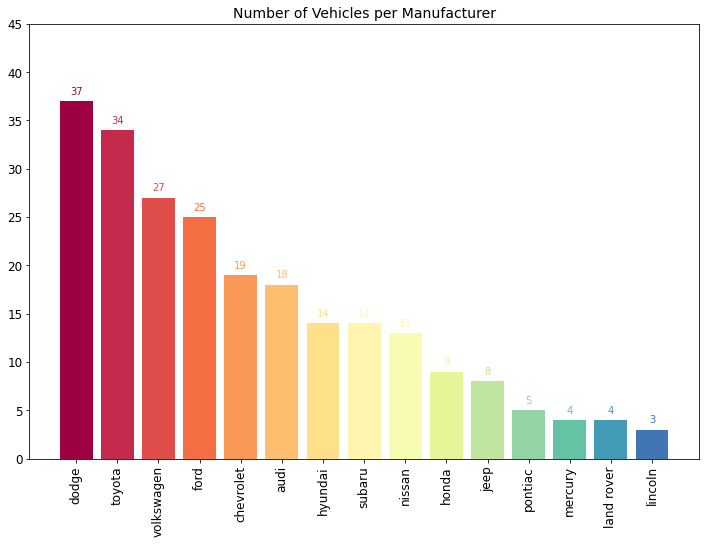

In [6]:
# get a dictionary with x and y from a dictionary
d = df["manufacturer"].value_counts().to_dict()

# create n colors based on the number of labels we have
colors = [plt.cm.Spectral(i/float(len(d.keys()))) for i in range(len(d.keys()))]


fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
ax.bar(d.keys(), d.values(), color = colors)

# iterate over every x and y and annotate the value on the top of the barchart
for i, (k, v) in enumerate(d.items()):
    ax.text(k, # where to put the text on the x coordinates
            v + 1, # where to put the text on the y coordinates
            v, # value to text
            color = colors[i], # color corresponding to the bar
            fontsize = 10, # fontsize
            horizontalalignment = 'center', # center the text to be more pleasant
            verticalalignment = 'center'
           )
# prettify the plot

# change the size of the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# change the ylim
ax.set_ylim(0, 45)

# set a title for the plot
ax.set_title("Number of Vehicles per Manufacturer", fontsize = 14)

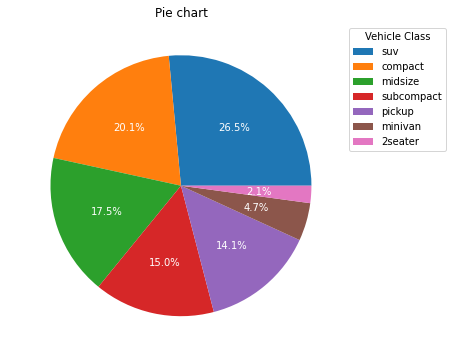

In [9]:
# create a dictionary of classes and their totals
d = df["class"].value_counts().to_dict()

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
ax.pie(d.values(), # pass the values from our dictionary
       labels = d.keys(), # pass the labels from our dictonary
       autopct = '%1.1f%%', # specify the format to be plotted
       textprops = {'fontsize': 10, 'color' : "white"} # change the font size and the color of the numbers inside the pie
      )

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# set the title
# set the title
ax.set_title("Pie chart")

# set the legend and add a title to the legend
ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "Vehicle Class")

In [8]:
# set the title
#ax.set_title("Pie chart")

# set the legend and add a title to the legend
#ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "Vehicle Class")

[Text(0.5, 1.0, 'Nested pie chart'), None]

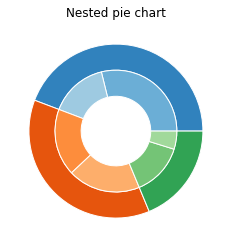

In [11]:
# get the data
size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

# create the outer and inner colors
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig, ax = plt.subplots()

# plot the data
# outer level
ax.pie(vals.sum(axis = 1), # plot the total [60., 32.] = 92
       radius = 1, 
       colors = outer_colors,
       wedgeprops = dict(width = size, edgecolor = 'w'))

# inner level
ax.pie(vals.flatten(), # using flatten we plot 60, 32 separetly
       radius = 1 - size, 
       colors = inner_colors,
       wedgeprops = dict(width = size, edgecolor = 'w'))

# set the title for the plot
ax.set(aspect = "equal", title = 'Nested pie chart')